the shape of features is: (42000, 784)
the shape of labels is: (42000,)
the range of features is: 0 to 255
the range of labels is: 0 to 9
label 1 is 1
label 2 is 0
label 3 is 1
label 4 is 4
label 5 is 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 346,742
Trainable params: 346,742
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/300
 - 2

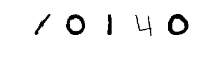

In [3]:
from __future__ import print_function               # Allows for python3 printing
import tensorflow
import keras
from keras.models import Sequential                 # import the sequential model, which is a core object in Keras
from keras.layers import Dense, Activation          # import the dense layer, AKA the fully connected layer
                                                    # and Keras' library of activation functions
from keras.optimizers import SGD                    #  import SGD as optimizer

import pandas                                       # Data storage
from sklearn.model_selection import train_test_split# Splits dataset

dataset = pandas.read_csv("train.csv") # Read in data
dataset = dataset.as_matrix() # Convert to ndarray
X,y = dataset[:,1:], dataset[:,0] # Separate data points and labels


print ('the shape of features is:',X.shape)       #print data shape
print ('the shape of labels is:',y.shape)       #print data shape

import numpy as np
print ('the range of features is:',np.min(X),'to',np.max(X))
print ('the range of labels is:',np.min(y),'to',np.max(y))

import matplotlib.pyplot as plt

for i in range(5):
    image = X[i]
    plt.subplot(1,10, i+1)
    image = image.reshape(28,28)
    print ('label', i+1, 'is',y[i])
    plt.imshow(image, cmap='Greys')
    plt.axis('off')


# The training and testing data are 28 by 28 images, and thus the total number of features is 28 x 28 = 784.
# 
# ## 4. Prepare the data
# Here we need to divide it by 255 for normalization, since the features are pixels value from 0 to 255. After that, we will use function from keras **utils.to.categoriacal** to do one-hot encoding. 

# In[4]:


x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20) # Split data

x_train = x_train/255.0                           # normalize training data
x_val = x_val/255.0                             # normalize testing data

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_val = keras.utils.to_categorical(y_val, num_classes=10)


# ## 5.1 Create the model
# We want to set several parameters at the beginning so that we can easily see them and change them. It would also be clear to others when reading your code and try to see what parameter you used. Here the most important parameters to set are training epochs, batch size, and learning rate. 
# 
# Batch size refers to the portion of the entire sample that you want to put into the neural network for training. One epoch is when all samples are trained once. Learning rate is how fast you want the model to train, but large learning rates would likely to cause problems such as missing the optimal solution (overshoot).

# In[5]:


# set parameters
batch_size = 256
epochs = 300
learning_rate = 0.001

# build the model
model = Sequential()                                         # define model to be sequential
model.add(Dense(300, activation='relu',input_dim=784))       # first hidden layer with 256 neurons
model.add(Dense(256, activation='relu'))                     # second hidden layer with 256 neurons
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))                   # output layer
model.summary()                                              # print out summary for all layers 


my_optimizer = keras.optimizers.RMSprop(lr=learning_rate)                   # using learning rate 0.001
model.compile(optimizer=my_optimizer,                        # using SGD with our set lr as optimizer
              loss='categorical_crossentropy',               # using cross entropy loss
              metrics=['accuracy'])                          # metric that is called during evaluation


best_weights_filepath = './best_weights.hdf5' ##define the filename to store
                                            ##the best performance and weights
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc',
                                              patience = 10) 
#Stop training early if val_acc doesn't improve for 5 epochs

SaveBestWeights = keras.callbacks.ModelCheckpoint(best_weights_filepath,
                                                  monitor='val_acc',
                                                  save_best_only=True)
# store the historically best performing weights in best_weights_filepath
#, where performance is given by accuracy on the validation set.


model_history = model.fit(x_train, y_train,                   # training data 
                    batch_size=batch_size,                   # batch size 256
                    epochs=epochs,                           # 15 epochs 
                    verbose= 2,                              # verbose level
                    validation_data = (x_val, y_val),  #Use the previously defined x_test as a validation set. 
                    callbacks = [earlyStopping, SaveBestWeights]
                         )     
model.load_weights(best_weights_filepath) ##Set the best performing weights to the model


# ## 6. Evaluate the model:Submission to Kaggle
# We first need to read in the data and then convert it into a numpy array so we can perform numpy operations on it. Next, we will make predictions for the Kaggle test set. We cannot evaluate our performance on this test set, as Kaggle keeps these a secret so that we can't cheat. (Cheating is actually really easy, but they're really good at telling when it happens)
# 
# To be clear, we defined an evaluation set above

# In[ ]:


testset = pandas.read_csv("test.csv")             # Read data
testset = testset.as_matrix()                     # Convert to ndarray
testset = testset/255.0                             # normalize testing data
predictions = model.predict_classes(testset)           # Predict


# In[ ]:


submission = pandas.DataFrame(data=predictions, index=np.arange(1,len(predictions)+1), columns=['Label']) # Create dataframe
submission.index.name = 'ImageId' # Set index name

csv_text = submission.to_csv() # Convert to text

# Write to file 'submission.csv'
with open("submission.csv",'w') as csv_file:
    csv_file.write(csv_text)

